In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob           # Allows to list out files within a directory
import librosa                  # Working with audio
import librosa.display
import IPython.display as ipd   # Allows to play audio files in notebook
from itertools import cycle
from librosa.feature import zero_crossing_rate

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [108]:
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

## Initial Audio Processing and Waveform Generation
To begin processing audio data, we first need to load the audio file into our Python environment. This is commonly done using libraries such as `librosa`, which provides convenient functions for audio analysis.

#### Steps
1. Import necessary libraries.
2. Load the audio files, returning the audio time series `y` and the sampling rate `sr`.
3. Visualise the waveform (time domain), plotting amplitude over time.
4. Convert and plot the frequency domain using Short-Time Fourier Transform to extract content.
5. Visualise with a spectrogram.

In [109]:
# Select Audio File and Play
i = 41
ipd.Audio(ds[i])

In [110]:
y, sr = librosa.load(ds[i])

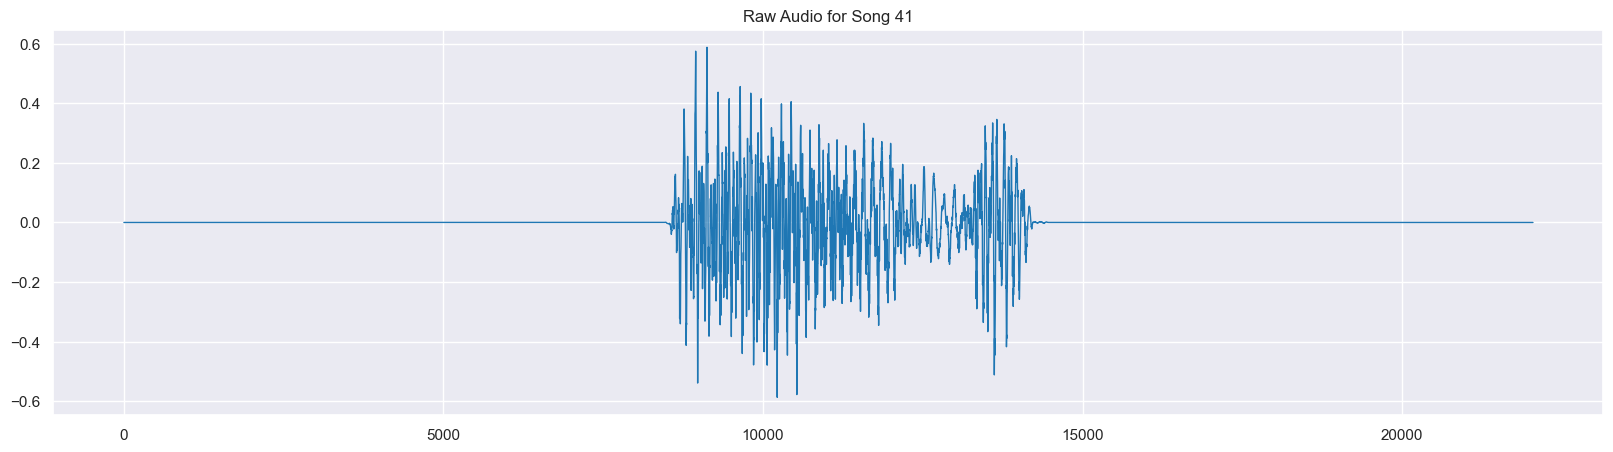

In [111]:
pd.Series(y).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Raw Audio for Song {i}",
                  color=color_pal[0])
plt.show()

### Trimming Silence for Clean Visualisation
When visualizing or analyzing audio, it's important to reduce noise and silence to focus on the meaningful parts of the signal.

Trimming helps:
- Improve clarity of waveform/frequency plots.
- Speed up downstream processing (e.g., speech recognition).
- Focus on relevant audio segments (e.g., spoken words, music).

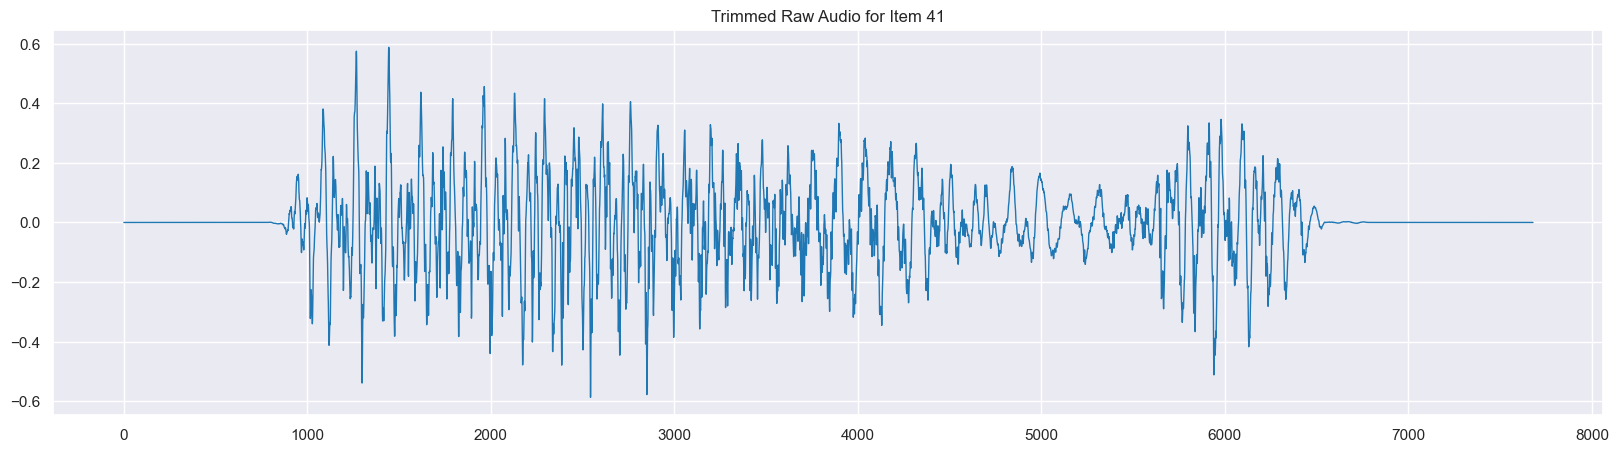

In [112]:
# Trimming Silence from Audio
y_trimmed, sr_trimmed = librosa.effects.trim(y, top_db=40)

pd.Series(y_trimmed).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Trimmed Raw Audio for Item {i}",
                  color=color_pal[0])
plt.show()

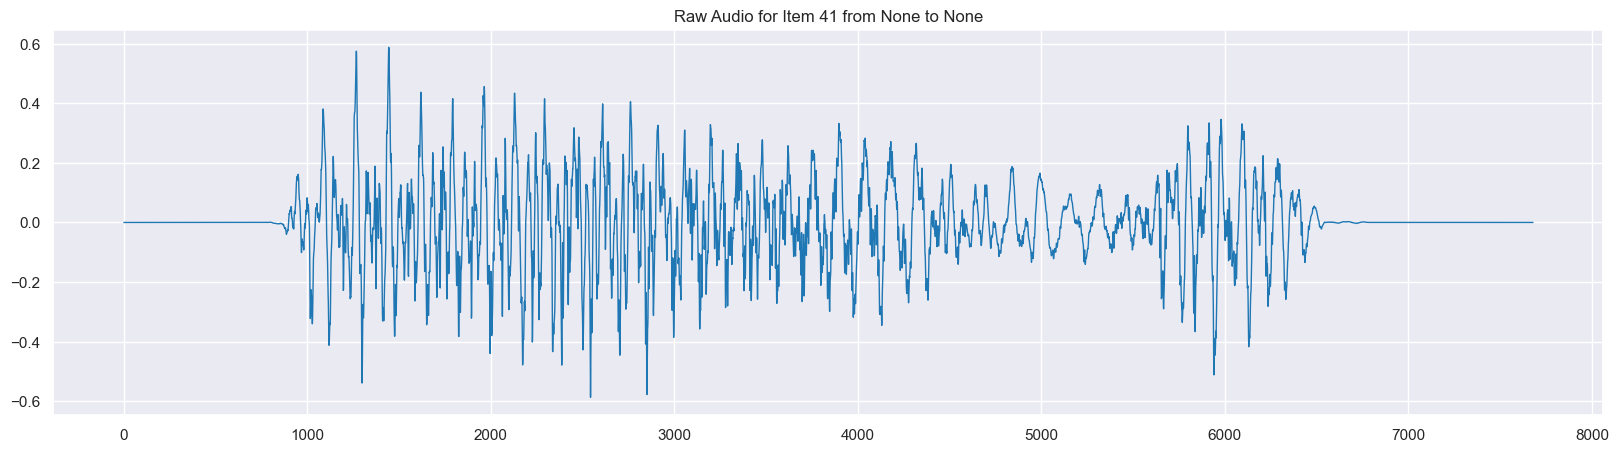

In [113]:
# Manual Trimming for Visualisation Purposes
start, end = None, None
pd.Series(y_trimmed[start:end]).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Raw Audio for Item {i} from {start} to {end}",
                  color=color_pal[0])
plt.show()

In [114]:
# Method Determining Silence Ratio
def silence_ratio(time_series, threshold=0.01):
    rms = librosa.feature.rms(y=time_series)[0]
    silent_frames = np.sum(rms < threshold)
    return (silent_frames / rms.size)

In [115]:
# Visualisation Plotting Silence Ratio Before and After Trim
def compare_ratios(y1=y, y2=y_trimmed):
    # Obtain Ratios
    pre_trim, post_trim = silence_ratio(y1), silence_ratio(y2)

    plt.figure(figsize=(12, 6))
    # Before trimming
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y1, sr=sr)
    plt.title(f'Original Waveform of File {i} (Silence Ratio: {pre_trim:.2%})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # After trimming
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(y2, sr=sr)
    plt.title(f'Trimmed Waveform of File {i} (Silence Ratio: {post_trim:.2%})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

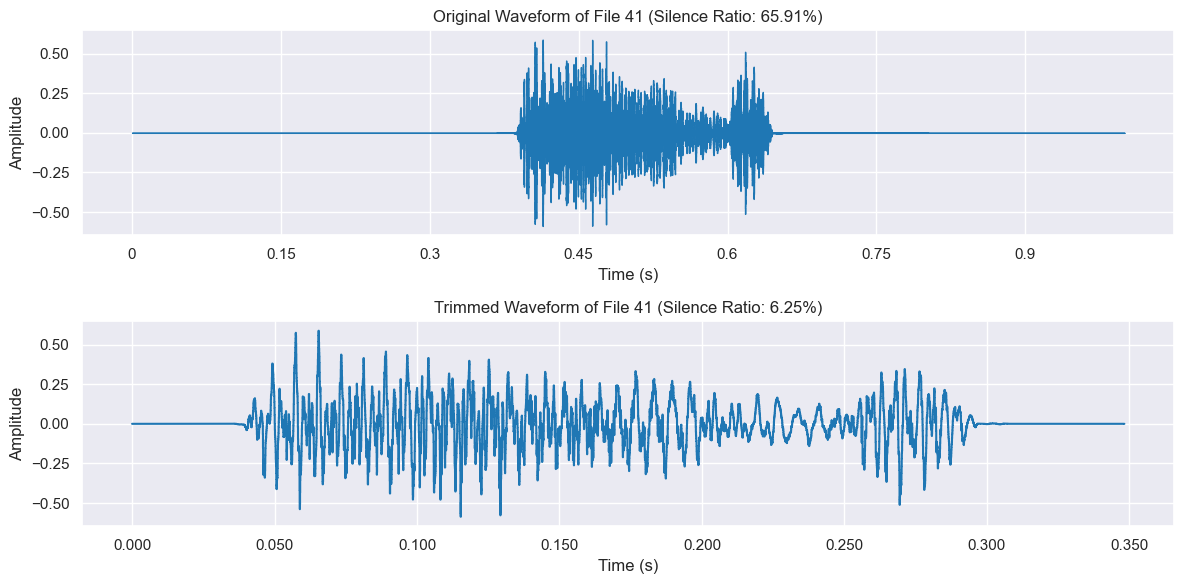

In [116]:
compare_ratios()

In [117]:
# Frequency Spectrum Visualisation
from scipy.fft import fft

def freq_spec(y1=y):
    n = len(y1)
    frequencies = np.fft.fftfreq(n, d=1/sr)
    magnitudes = np.abs(fft(y1))

    plt.figure(figsize=(12, 4))
    plt.plot(frequencies[:n // 2], magnitudes[:n // 2])
    plt.title(f'Frequency Spectrum for File {i}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

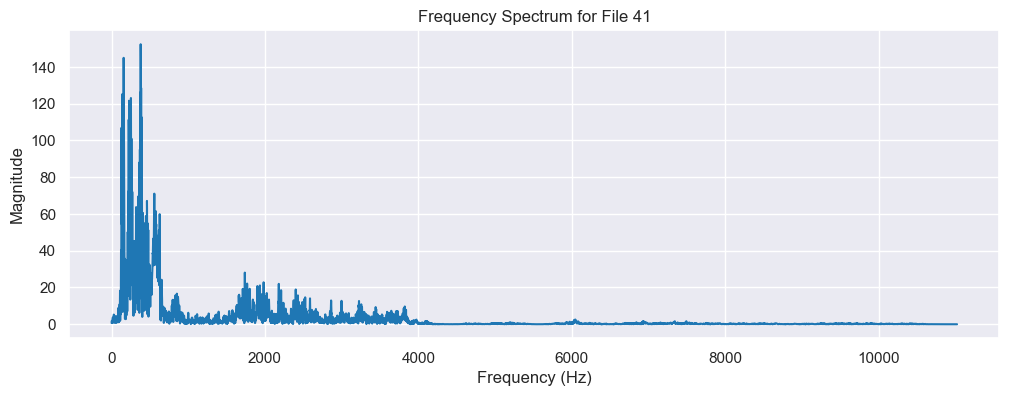

In [118]:
freq_spec()

In [119]:
# Spectrogram
def spectrogram(y1=y):
    D = librosa.stft(y1)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(S_db,
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax)
    ax.set_title(f'Spectogram for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

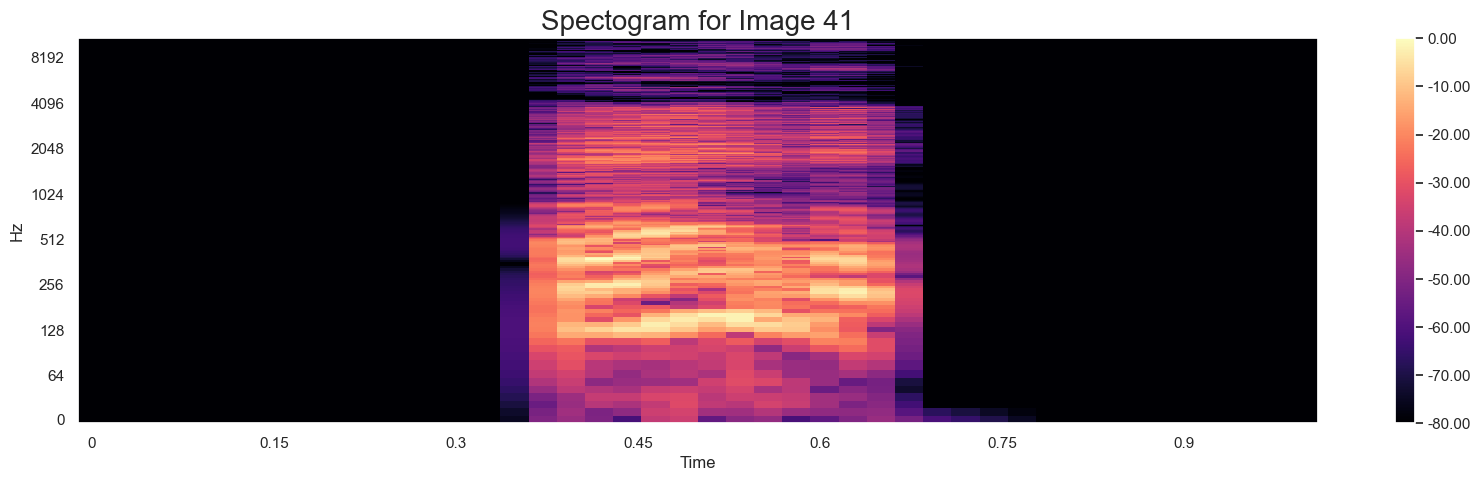

In [120]:
spectrogram()

## Audio Feature Extraction and Visualisation
After generating spectrograms, we can extract and visualise several key audio features that provide insights into the characteristics of the audio signal. These features are widely used in audio analysis, music information retrieval (MIR), and speech processing.

#### Log-Mel Spectrogram
Converts the linear frequency scale (Hz) to the Mel scale, which better approximates human auditory perception. It is derived by:
1. Computing the Mel spectrogram (filtering frequencies into Mel bands).
2. Converting the power values to decibels (dB) using a logarithmic scale.

Key Insights:
- Emphasises perceptually relevant frequencies.
- Useful for speech and music classification tasks.

In [121]:
# Mel Spectrogram
def mel_spec(y1=y):
    S = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128, fmax=8000)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(S_db_mel,
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax)
    ax.set_title(f'Mel Spectogram for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

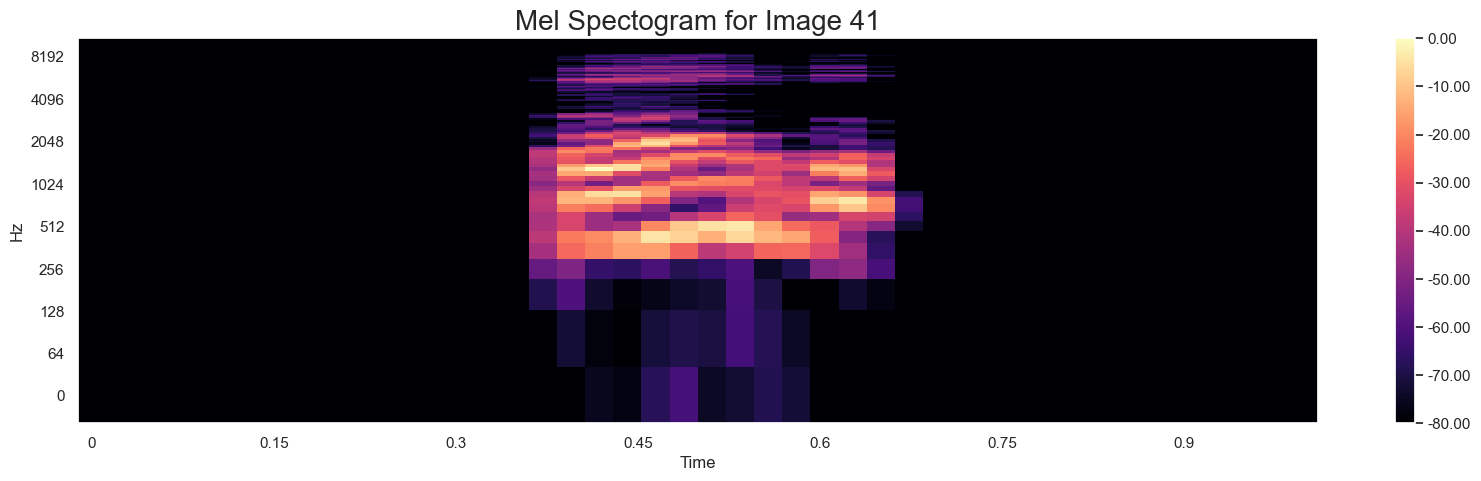

In [122]:
mel_spec()

### Mel Frequency Cepstral Coefficients (MFCCs)
MFCCs are a compact representation of the spectral envelope, derived by:
1. Taking the logarithm of the Mel spectrogram.
2. Applying the Discrete Cosine Transform (DCT) to decorrelate the coefficients.

Properties:
- Captures timbral/textural features (e.g. voice characteristics)
- The first 12-20 coefficients are typically used for analysis.

Visualisation:
- The plot shows how MFCCs evolve over time, with each coefficient representing a different aspect of the audio's spectral shape.

In [123]:
# Mel Frequency Cepstral Coefficients (MFCCs)
def mfcc(y1=y):
    mfcc = librosa.feature.mfcc(y=y1, sr=22050, n_mfcc=20, n_mels=256, fmax=8000)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)

    ax.set_yticks(np.arange(0, mfcc.shape[0], 5))
    ax.set_yticklabels(np.arange(0, mfcc.shape[0], 5))

    ax.set_title(f'MFCCs for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_ylabel('MFCC Coefficient Index')
    ax.set_xlabel('Time (s)')
    plt.show()

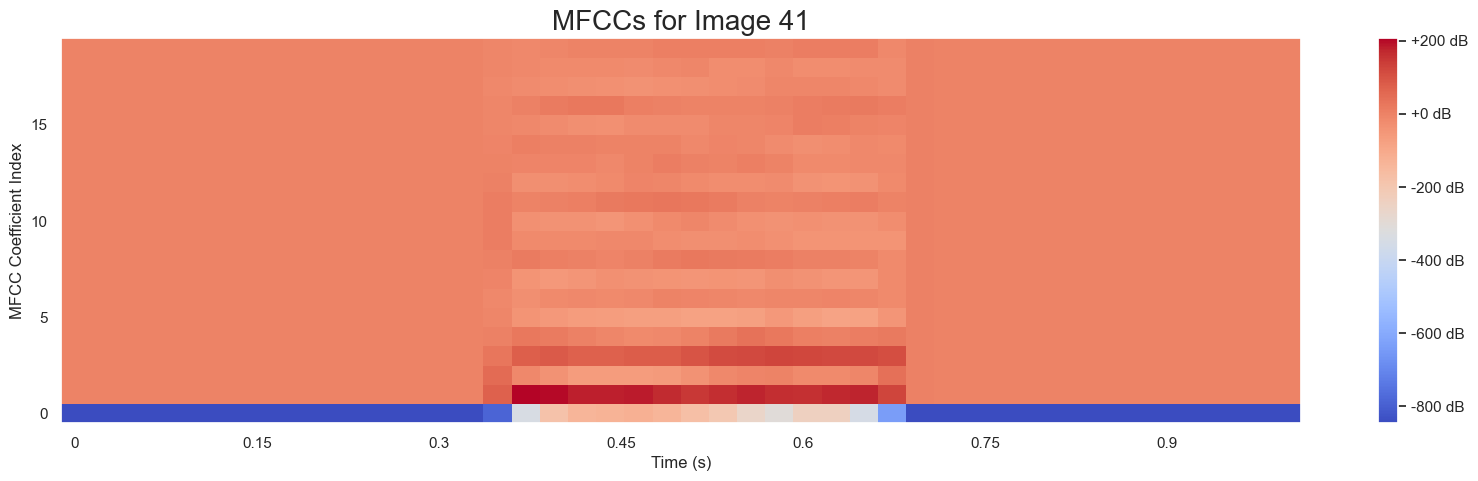

In [124]:
mfcc()

### Zero Crossing Rate (ZCR)
ZCR measures the rate at which the audio signal crosses zero amplitude.

Applications:
- Indicator of noisiness or percussiveness (e.g., speech vs. silence, drum sounds).
- Higher ZCR values often correspond to unvoiced speech or noise.

Plot:
- The ZCR is plotted over time, showing regions of high activity (e.g., consonants in speech or transient sounds in music).

In [125]:
# Zero Crossing
def zero_crossing(y1=y):
    # Calculate zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y1)
    frames = range(zcr.shape[1])  # Ensure you use the correct frame count
    times = librosa.frames_to_time(frames, sr=sr)

    # Plot ZCR
    plt.figure(figsize=(10, 4))
    plt.plot(times, zcr[0], label='ZCR')
    plt.title(f'Zero Crossing Rate Over Time for Image {i}', fontsize=16)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('ZCR', fontsize=12)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

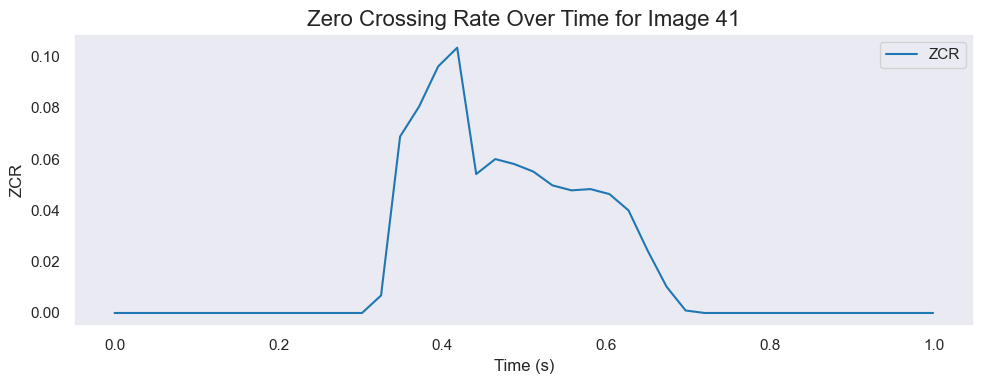

In [126]:
zero_crossing()

### Spectral Centroid
The Spectral Centroid represents the "center of mass" of the frequency spectrum, calculated as the weighted mean of frequencies.

Interpretation:
- Higher values indicate brighter/treble-heavy sounds.
- Lower values correspond to brass-heavy or muffled sounds.

Visualisation:
- Overlaid on the waveform to correlate temporal events with spectral changes.

In [127]:
# Spectral Centroid
def spec_cent(y1=y):
    centroids = librosa.feature.spectral_centroid(y=y1, sr=sr)[0]
    frames = range(len(centroids))
    t = librosa.frames_to_time(frames, sr=sr)

    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(y1, sr=sr, alpha=0.4)
    plt.plot(t, centroids, color='b', label='Spectral Centroid')
    plt.title('Spectral Centroid Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude / Centroid')
    plt.legend()
    plt.show()

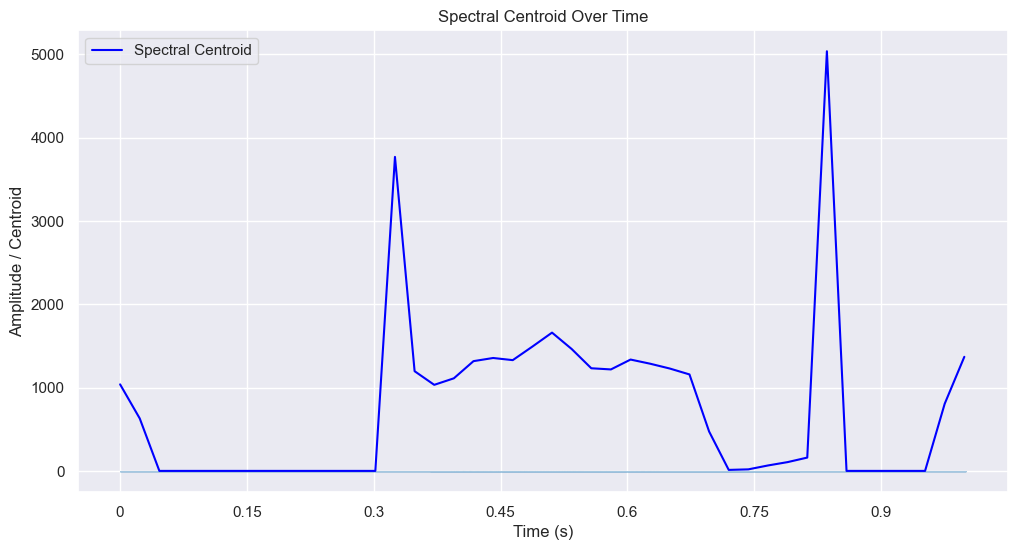

In [128]:
spec_cent()

### Constant-Q Transform (CQT)
The CQT provides a time-frequency representation where frequency bins are geometrically spaced (matched musical pitch intervals).

Advantages:
- Better resolution for lower frequencies than the SFTF.
- Aligns with musical notes (logarithmic frequency axis).

Plot:
- The CQT spectrogram shows harmonic structures and pitch content over time.

In [129]:
# Constant-Q Transform (CQT)
def cqt(y1=y):
    C = librosa.cqt(y=y1, sr=sr, n_bins=60, bins_per_octave=12, scale=False)
    C_db_mel = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(C_db_mel, x_axis='time', y_axis='cqt_note', ax=ax)
    ax.set_title(f'CQT for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

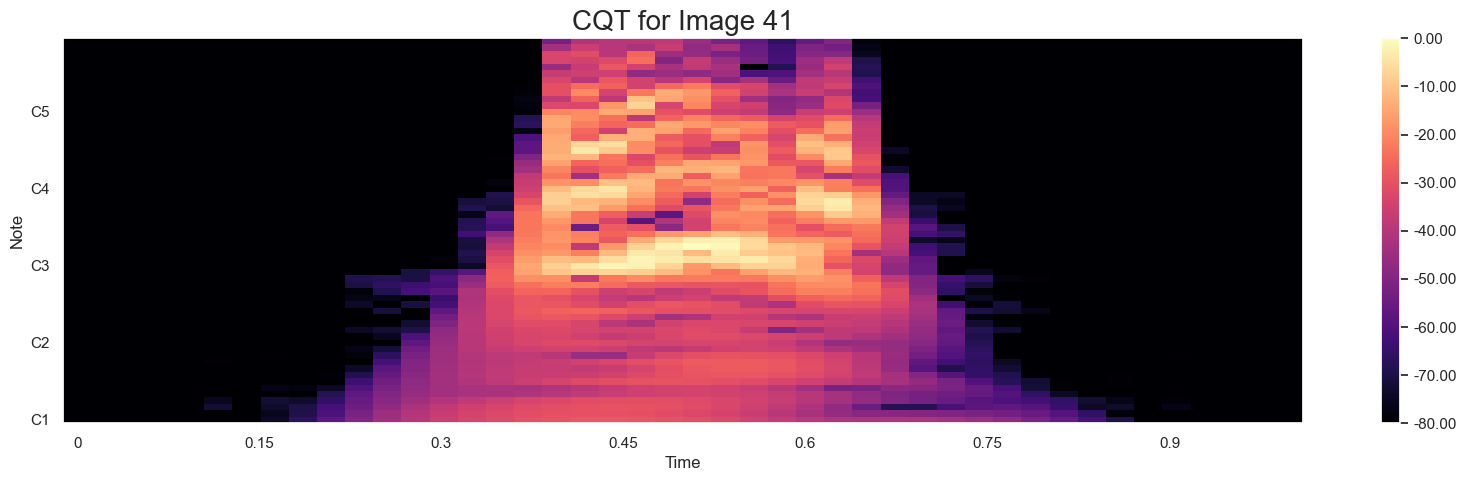

In [130]:
cqt()

### Chroma Feature
The Chroma Feature maps the spectrum to 12 bins representing the 12 semitones of the musical octave.

Use Cases:
- Chord Recognition
- Music Similarity (ignoring timbral/octave differences)

Visualisation:
- The plot highlights the dominance of musical notes (C, C#, D, etc.) over time, useful for harmonic analysis.

In [131]:
# Construct Chroma Feature Visualization
def chroma_feature(y=y):
    C = librosa.cqt(y=y_trimmed, sr=sr, n_bins=60, bins_per_octave=12, scale=False)
    chroma = librosa.feature.chroma_cqt(C=np.abs(C), sr=sr)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax)
    ax.set_title(f'Chroma for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=240
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=120
  warnings.warn(


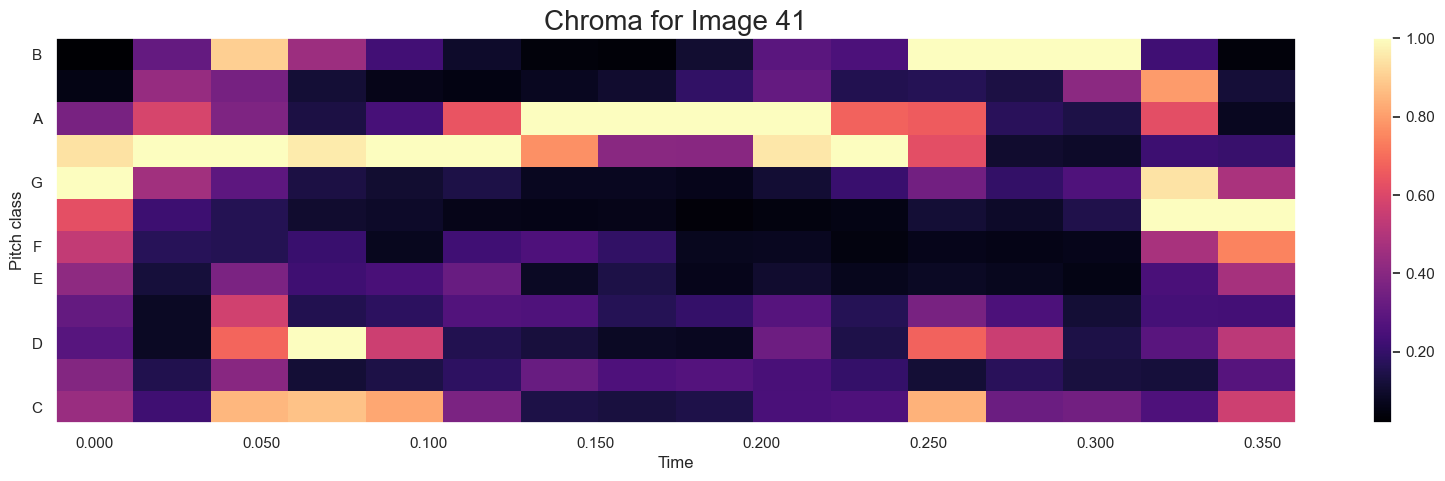

In [132]:
chroma_feature()